# Linear regression with multiple features

## Create some data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
np.random.seed(314) 

N = 100  # num data points
alpha_real = 2.5  # offset
beta_real = [0.9, 1.5]  # 2 beta parameters --> 2 features
eps_real = np.random.normal(0, 0.5, size=N)  # gaussian noise

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])  # 2 features
X_mean = X.mean(axis=1, keepdims=True) 
X_centered = X - X_mean  # Centre the independent variable
print('X_centered shape:', X_centered.shape)

y = alpha_real + np.dot(beta_real, X) + eps_real  # (1, 2) dot (2, N) -> (1, N)
print('y shape:', y.shape)

X_centered shape: (2, 100)
y shape: (100,)


In [20]:
def scatter_plot(x, y):
    """ Plot relationship between dependent variable & each feature.
    Also plot relationships between features.
    Hardcoded for 2 features.
    """
    plt.figure(figsize=(10, 10)) 
    rows, cols = 2, 2
    for idx, x_i in enumerate(x): 
        plt.subplot(rows, cols, idx+1) 
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16) 
        plt.ylabel('$y$', rotation=0, fontsize=16)
        
    plt.subplot(rows, cols, idx+2) 
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16) 
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

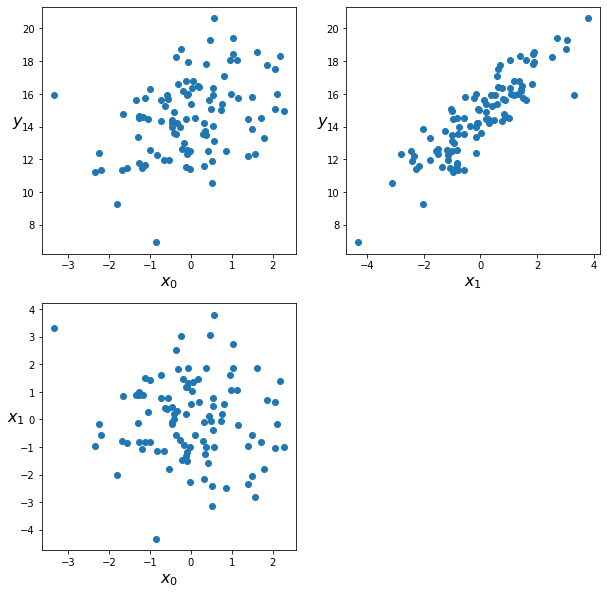

In [21]:
scatter_plot(X_centered, y)

## Define the linear regression model

In [22]:
import pymc3 as pm

In [28]:
model_mlr = pm.Model()
with model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)  # offset
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)  # gradient for each feature
    epsilon = pm.HalfCauchy('epsilon', 5)  # Noise
    
    mu = alpha_tmp + pm.math.dot(beta, X_centered)  # mean (no noise)
    
    # Get the equivalent alpha for the uncentered data 
    # 1) Write out the linear model with centered data
    # 2) Adjust alpha to get equation back into same form
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean))  
    
    ypred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    

## Perform the inference

In [29]:
with model_mlr:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000)

logp = -75.778, ||grad|| = 32.757: 100%|██████████| 41/41 [00:00<00:00, 1762.01it/s]   
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The f

/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/sean/anaconda3/envs/bayesian_data_analysis_with_python/lib/python3.7/s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2b8efe310>,
      dtype=object)

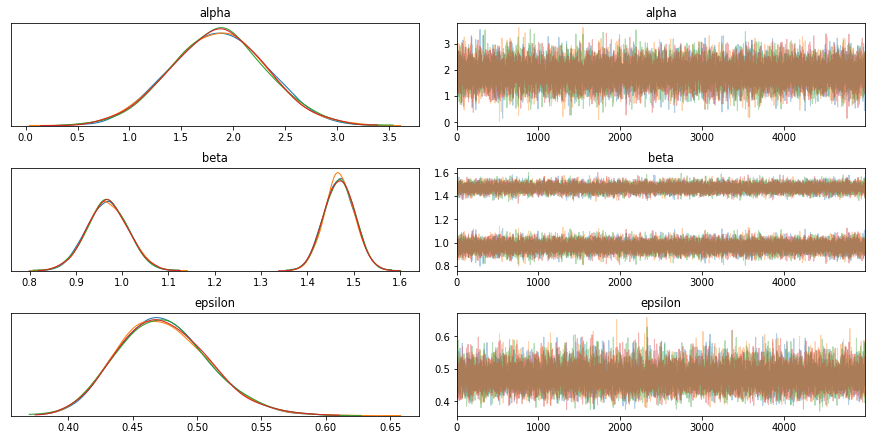

In [30]:
varnames = ['alpha', 'beta', 'epsilon']
pm.traceplot(trace_mlr, varnames)

In [32]:
pm.summary(trace_mlr, varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.858,0.458,0.958,2.680,0.003,0.002,21964.0,20996.0,21982.0,15520.0,1.0
beta[0],0.968,0.044,0.887,1.053,0.000,0.000,22673.0,22673.0,22697.0,15447.0,1.0
beta[1],1.470,0.033,1.409,1.531,0.000,0.000,20880.0,20880.0,20853.0,15223.0,1.0
epsilon,0.474,0.035,0.412,0.542,0.000,0.000,20348.0,20091.0,20604.0,16192.0,1.0
